* This notebook was made to reproduce drifter track with reference of Nancy's notebook with longitude ticks shown completely in the figure.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io
import datetime as dt

from salishsea_tools import nc_tools, viz_tools, tidetools, bathy_tools,geo_tools
import drifter

In [2]:
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

In [3]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy = grid.variables['Bathymetry'][:, :]
X = grid.variables['nav_lon'][:, :]
Y = grid.variables['nav_lat'][:, :]

In [4]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']

In [5]:
def convert_time(matlab_time_array):
    "converts a matlab time array to python format"
    python_time_array=[]
    for t in matlab_time_array:
        python_datetime = dt.datetime.fromordinal(int(t)) + dt.timedelta(days=t%1) - dt.timedelta(days = 366)
        python_time_array.append(python_datetime)
    
    python_time_array = np.array(python_time_array)
    return python_time_array

In [6]:
def get_tracks(switch,lats,lons,ptime,in_water):
    """returns a list of tracks of each buoy, 
    ie a trajectory for each time the buoy was released into the water"""
    all_tracks=[]
    for ind in switch:
        track_on = 1
        i = ind
        track ={'time':[], 'lat':[],'lon':[]}
        while(track_on):
            if in_water[i]!=1:
                track_on=0
            elif i==np.shape(in_water)[0]-1:    
                track['time'].append(ptime[i])
                track['lat'].append(lats[i])
                track['lon'].append(lons[i])
                track_on=0
            else:
                track['time'].append(ptime[i])
                track['lat'].append(lats[i])
                track['lon'].append(lons[i])
            i=i+1
        all_tracks.append(track)
        
    return all_tracks

In [7]:
def organize_info(buoy,btype):
    """ organizes the buoy info. Groups the buoy data into tracks for when it was released into the water. """
    #creat arrays for easier access
    buoy_name = btype[buoy][0]
    lats = btype[buoy]['lat'].flatten()
    lons = btype[buoy]['lon'].flatten()
    mtime = btype[buoy]['mtime']
    in_water = btype[buoy]['isSub'].flatten()
    #convert mtime to python datetimes
    ptime = convert_time(mtime)
    
    #loop through in_water flag to find when buoy switched from being out of water to being in water. 
    switch = []; 
    for ind in np.arange(1,in_water.shape[0]):
        if int(in_water[ind]) != int(in_water[ind-1]):
            if int(in_water[ind])==1:
                switch.append(ind)
    
    all_tracks=get_tracks(switch,lats,lons,ptime.flatten(),in_water)
    
    return buoy_name, all_tracks

In [8]:


def find_start(tracks, start_date):
    """returns the a list of indices for a track released on start date.
    Only checks the month and day of the start day"""
    i=0
    ind=[]
    starttimes=[]
    for t in tracks:   
        if int(t['time'][0].month) == start_date.month:
                if int(t['time'][0].day) == start_date.day:
                    ind.append(i)
        i=i+1
        
    return ind



In [9]:
def plot_buoy(tracks, startdate, i=0, fancy=False):
    """ plots a buoy trajectory at the given startdate in an axis, ax.
    returns the trajectory that was plotted.
    The first track released on the startdate is plotted.
    For trajectories that were released mulitples times a day, i selects which release is plotted.
    """
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    
    ind =find_start(tracks,startdate)
    traj=tracks[ind[i]]
    duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
    print ('Released', traj['time'][0], 'at', traj['lat'][0], ',' , traj['lon'][0], 'for' , duration, 'hours')
    ax.plot(traj['lon'],traj['lat'],'ob')
    ax.plot(traj['lon'][0],traj['lat'][0],'sr')
    
    bathy, X, Y = tidetools.get_SS2_bathy_data()
    [j,i]=geo_tools.find_closest_model_point(float(traj['lon'][0]),float(traj['lat'][0]),X,Y,land_mask=bathy.mask)
    ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    if fancy:
        cmap = plt.get_cmap('winter_r')
        cmap.set_bad('burlywood')
        ax.pcolormesh(X, Y, bathy, cmap=cmap)
        ax.set_title('Observed Drift Track')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.text(-123.15,49.13, "Fraser River", fontsize=12)
    else:
        viz_tools.plot_coastline(ax, grid, coords='map')
        viz_tools.plot_coastline(ax, grid, coords='map',isobath=4)
        viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)
        print ('NEMO coords:', j,i)
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.4])
    ax.set_xticks([-123.6, -123.4, -123.2,-123])
    ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()
    return traj

In [27]:
def calculate_position_onehour(tracks, startdate,day,hour, minute, filename, i=0):
    """
    """
    ind =find_start(tracks,startdate)
    traj=tracks[ind[i]]
    duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
    print ('Released', traj['time'][0], 'at', traj['lat'][0], ',' , traj['lon'][0], 'for' , duration, 'hours')
    
    bathy, X, Y = tidetools.get_SS2_bathy_data()
    [j,i]=geo_tools.find_closest_model_point(float(traj['lon'][0]),float(traj['lat'][0]),X,Y,land_mask=bathy.mask)
    print(j,i,traj['time'][0].hour+0.5+traj['time'][0].minute/60)
    
    fig,ax = plt.subplots(1,1,figsize=(5,5)) 
    ax.plot(traj['lon'],traj['lat'],'ob')
    ax.plot(traj['lon'][0],traj['lat'][0],'sr')
    ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    viz_tools.plot_coastline(ax, grid, coords='map')
    viz_tools.plot_coastline(ax, grid, coords='map',isobath=4)
    viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.4])   
    
    with open(filename, 'w') as file:
        for t in range(len(traj['time'])):

            if np.abs((traj['time'][t] - dt.datetime(2014,10,day,hour,minute)).seconds)<=50:

                [j,i]=geo_tools.find_closest_model_point(float(traj['lon'][t]),float(traj['lat'][t]),X,Y,land_mask=bathy.mask)
                print(j,i,(traj['time'][t].day-8)*24+traj['time'][t].hour+0.5+traj['time'][t].minute/60, traj['time'][t])
                t_time = (traj['time'][t].day-8)*24+traj['time'][t].hour+0.5+traj['time'][t].minute/60
                file.writelines('%s %s %s \n' %(i+1,j+1,t_time))
                ax.plot(traj['lon'][t],traj['lat'][t],'*')
                hour = hour +1
                if hour > 23:
                    hour = 0
                    day = day +1
    file.close()                
    plt.show()
    return traj

UBC-I-0001
Released 2014-10-08 16:00:06.999999 at 49.0862766667 , -123.320955 for 26.500277778055555 hours
425 288 16.5
425 288 16.5 2014-10-08 16:00:06.999999
422 283 17.5 2014-10-08 17:00:06.999996
419 279 18.5 2014-10-08 18:00:37.999995
420 274 19.5 2014-10-08 19:00:08.000004
421 270 20.5 2014-10-08 20:00:08
423 266 21.5 2014-10-08 21:00:07.000002
424 262 22.5 2014-10-08 22:00:08.000004
426 258 23.5 2014-10-08 23:00:08
424 255 24.5 2014-10-09 00:00:37
423 252 25.5 2014-10-09 01:00:06.999999
421 250 26.5 2014-10-09 02:00:11.000004
419 248 27.5 2014-10-09 03:00:09.000001
418 247 28.5 2014-10-09 04:00:08.000004
417 246 29.5 2014-10-09 05:00:08
416 245 30.5 2014-10-09 06:00:37.999995
416 245 31.5 2014-10-09 07:00:06.999999
416 245 32.5 2014-10-09 08:00:08
416 245 33.5 2014-10-09 09:00:07.999997
416 245 34.5 2014-10-09 10:00:08.000004
417 245 35.5 2014-10-09 11:00:06.999996
417 244 36.5 2014-10-09 12:00:37.999995
417 244 37.5 2014-10-09 13:00:08.000004
416 244 38.5 2014-10-09 14:00:08
41

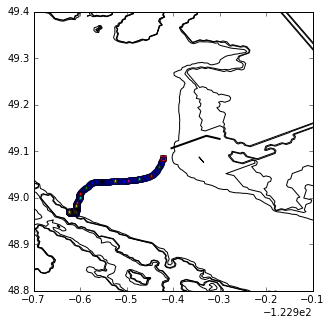

In [28]:
buoy = 0
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,16,0,'test.txt',i=-1)

UBC-I-0001
Released 2014-10-08 16:00:06.999999 at 49.0862766667 , -123.320955 for 26.500277778055555 hours
NEMO coords: 425 288


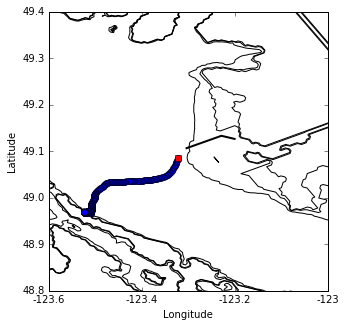

In [12]:
buoy = 0
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
t_j = plot_buoy(tracks,dt.datetime(2014,10,8),i=-1)

In [10]:
fig.savefig('drop31.png')

UBC-I-0002
Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.499722222777777 hours
427 289 16.583333333333332
427 289 16.583333333333332 2014-10-08 16:05:07.999996
424 285 17.583333333333332 2014-10-08 17:05:08.000002
421 280 18.583333333333332 2014-10-08 18:05:07.999999
421 275 19.583333333333332 2014-10-08 19:05:07.000001
422 271 20.583333333333332 2014-10-08 20:05:06.999998
424 266 21.583333333333332 2014-10-08 21:05:07.000005
426 262 22.583333333333332 2014-10-08 22:05:07.999996
427 260 23.583333333333332 2014-10-08 23:05:08.000002
426 257 24.583333333333332 2014-10-09 00:05:07.999999
424 254 25.583333333333332 2014-10-09 01:05:07.999996
422 252 26.583333333333332 2014-10-09 02:05:08.999997
421 250 27.583333333333332 2014-10-09 03:05:07.999999
419 248 28.583333333333332 2014-10-09 04:05:07.000001
417 247 29.583333333333332 2014-10-09 05:05:06.999998
417 246 30.583333333333332 2014-10-09 06:05:07.000005
416 246 31.583333333333332 2014-10-09 07:05:07.000001

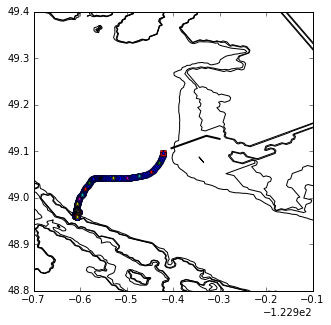

In [13]:
buoy = 1
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,16,5,i=-1)

UBC-I-0002
Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.499722222777777 hours
NEMO coords: 427 289


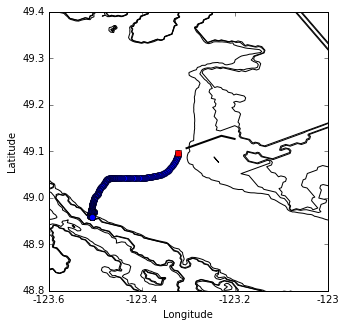

In [21]:
buoy = 1
name, tracks=organize_info(buoy,ubc)
print (name)
fig=plot_buoy(tracks,dt.datetime(2014,10,8),i=-1)

In [12]:
#fig.savefig('drop212a.png')

UBC-I-0003
Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.750277778333334 hours
429 290 16.666666666666668
429 290 16.666666666666668 2014-10-08 16:10:07.000003
428 288 17.666666666666668 2014-10-08 17:10:07
427 281 18.666666666666668 2014-10-08 18:10:06.999997
429 275 19.666666666666668 2014-10-08 19:10:07.999998
431 269 20.666666666666668 2014-10-08 20:10:08.000005
434 266 21.666666666666668 2014-10-08 21:10:08.000001
438 267 22.666666666666668 2014-10-08 22:10:07.999998
442 267 23.666666666666668 2014-10-08 23:10:07
445 270 24.666666666666668 2014-10-09 00:10:06.999997
446 272 25.666666666666668 2014-10-09 01:10:07.000003
446 275 26.666666666666668 2014-10-09 02:10:08.000005
445 276 27.666666666666668 2014-10-09 03:10:08.000001
443 277 28.666666666666668 2014-10-09 04:10:07.999998
441 278 29.666666666666668 2014-10-09 05:10:08.000005
438 278 30.666666666666668 2014-10-09 06:10:06.999997
435 278 31.666666666666668 2014-10-09 07:10:07.000003
435 277 32.66

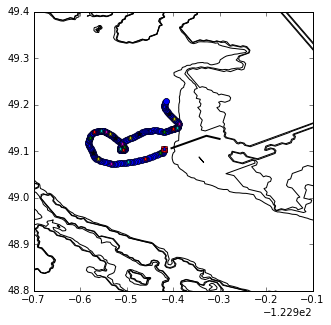

In [14]:
buoy = 2
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,16,10,i=-1)

UBC-I-0003
Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.750277778333334 hours
NEMO coords: 429 290


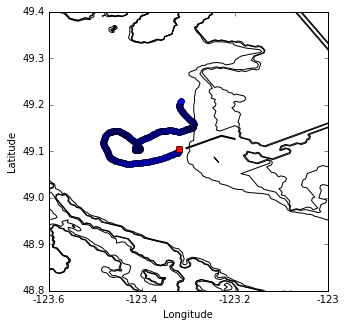

In [23]:
buoy = 2
name, tracks=organize_info(buoy,ubc)
print (name)
fig=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)

In [14]:
#fig.savefig('drop112a.png')

UBC-I-0004
Released 2014-10-08 17:30:08.000004 at 49.1064116667 , -123.320053333 for 28.249999998055557 hours
429 290 18.0
429 290 18.0 2014-10-08 17:30:08.000004
429 292 19.0 2014-10-08 18:30:08
431 295 20.0 2014-10-08 19:30:07.999997
434 299 21.0 2014-10-08 20:30:08.000004
436 303 22.0 2014-10-08 21:30:09.000005
436 306 23.0 2014-10-08 22:30:07.999997
435 308 24.0 2014-10-08 23:30:08.000004
433 308 25.0 2014-10-09 00:30:08
433 307 26.0 2014-10-09 01:30:07.999997
432 305 27.0 2014-10-09 02:30:08.000004
434 302 28.0 2014-10-09 03:30:09.000005
436 298 29.0 2014-10-09 04:30:07.999997
438 295 30.0 2014-10-09 05:30:08.000004
438 294 31.0 2014-10-09 06:30:08
438 295 32.0 2014-10-09 07:30:09.000001
438 296 33.0 2014-10-09 08:30:08.000004
438 297 34.0 2014-10-09 09:30:08
437 298 35.0 2014-10-09 10:30:07.999997
437 299 36.0 2014-10-09 11:30:08.000004
435 300 37.0 2014-10-09 12:30:06.999996
433 300 38.0 2014-10-09 13:30:07.999997
432 301 39.0 2014-10-09 14:30:08.000004
431 302 40.0 2014-10-09 1

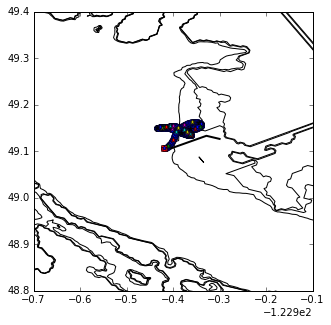

In [15]:
buoy = 3
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,17,30,i=-1)

UBC-I-0004
Released 2014-10-08 17:30:08.000004 at 49.1064116667 , -123.320053333 for 28.249999998055557 hours
NEMO coords: 429 290


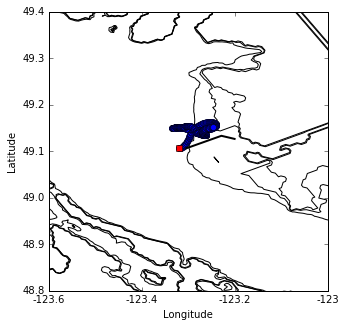

In [25]:
buoy = 3
name, tracks=organize_info(buoy,ubc)
print (name)
fig=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)

In [16]:
fig.savefig('drop112b.png')

UBC-I-0005
Released 2014-10-08 17:30:06.999999 at 49.0965066667 , -123.324513333 for 26.166944445 hours
427 288 18.0
427 288 18.0 2014-10-08 17:30:06.999999
428 282 19.0 2014-10-08 18:30:06.999996
429 277 20.0 2014-10-08 19:30:07.000002
432 273 21.0 2014-10-08 20:30:06.999999
434 271 22.0 2014-10-08 21:30:37.000004
438 270 23.0 2014-10-08 22:30:07.999997
441 272 24.0 2014-10-08 23:30:08.000004
443 274 25.0 2014-10-09 00:30:08
444 275 26.0 2014-10-09 01:30:07.999997
443 277 27.0 2014-10-09 02:30:08.999998
442 279 28.0 2014-10-09 03:30:09.000005
439 280 29.0 2014-10-09 04:30:07.999997
436 280 30.0 2014-10-09 05:30:08.000004
432 280 31.0 2014-10-09 06:30:08
431 279 32.0 2014-10-09 07:30:07.999997
433 278 33.0 2014-10-09 08:30:08.000004
435 278 34.0 2014-10-09 09:30:08
436 280 35.0 2014-10-09 10:30:07.000002
437 282 36.0 2014-10-09 11:30:08.999998
438 283 37.0 2014-10-09 12:30:08
437 284 38.0 2014-10-09 13:30:07.999997
436 286 39.0 2014-10-09 14:30:08.000004
435 287 40.0 2014-10-09 15:30:0

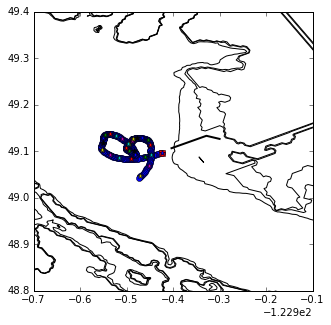

In [16]:
buoy = 4
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,17,30,i=-1)

UBC-I-0005
Released 2014-10-08 17:30:06.999999 at 49.0965066667 , -123.324513333 for 26.166944445 hours
NEMO coords: 427 288


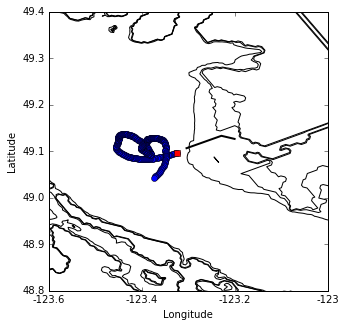

In [26]:
buoy = 4
name, tracks=organize_info(buoy,ubc)
print (name)
fig=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)

In [18]:
fig.savefig('drop212b.png')

UBC-I-0006
Released 2014-10-08 17:35:07.000001 at 49.08599 , -123.323693333 for 23.83333333222222 hours
425 287 18.083333333333332
425 287 18.083333333333332 2014-10-08 17:35:07.000001
423 278 19.083333333333332 2014-10-08 18:35:06.999998
424 270 20.083333333333332 2014-10-08 19:35:07.999999
426 263 21.083333333333332 2014-10-08 20:35:07.999996
429 258 22.083333333333332 2014-10-08 21:35:08.000002
430 254 23.083333333333332 2014-10-08 22:35:07.999999
431 251 24.083333333333332 2014-10-08 23:35:07.999996
432 248 25.083333333333332 2014-10-09 00:35:08.999997
432 246 26.083333333333332 2014-10-09 01:35:07.000005
432 245 27.083333333333332 2014-10-09 02:35:07.000001
431 244 28.083333333333332 2014-10-09 03:35:08.000002
430 242 29.083333333333332 2014-10-09 04:35:07.000005
428 235 30.083333333333332 2014-10-09 05:35:09
426 234 31.083333333333332 2014-10-09 06:35:08.000002
424 235 32.083333333333336 2014-10-09 07:35:07.999999
424 235 33.083333333333336 2014-10-09 08:35:07.999996
424 235 34.0

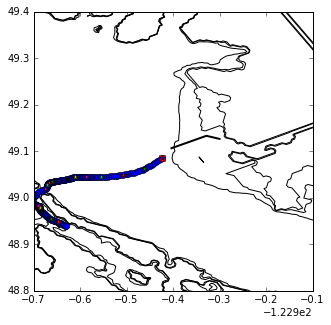

In [17]:
buoy = 5
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,17,35,i=-1)

UBC-I-0006
Released 2014-10-08 17:35:07.000001 at 49.08599 , -123.323693333 for 23.83333333222222 hours
NEMO coords: 425 287


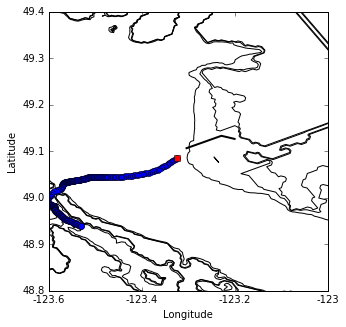

In [27]:
buoy = 5
name, tracks=organize_info(buoy,ubc)
print (name)
fig=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)

In [20]:
fig.savefig('drop323a.png')

UBC-I-0007
Released 2014-10-08 19:10:07.999998 at 49.0856266667 , -123.325655 for 23.08361111111111 hours
425 287 19.666666666666668
425 287 19.666666666666668 2014-10-08 19:10:07.999998
425 277 20.666666666666668 2014-10-08 20:10:08.000005
428 271 21.666666666666668 2014-10-08 21:10:08.000001
430 266 22.666666666666668 2014-10-08 22:10:07.999998
431 263 23.666666666666668 2014-10-08 23:10:08.000005
431 261 24.666666666666668 2014-10-09 00:10:08.000001
430 258 25.666666666666668 2014-10-09 01:10:07.999998
429 254 26.666666666666668 2014-10-09 02:10:08.000005
428 251 27.666666666666668 2014-10-09 03:10:08.000001
428 249 28.666666666666668 2014-10-09 04:10:07.000003
427 247 29.666666666666668 2014-10-09 05:10:07
426 246 30.666666666666668 2014-10-09 06:10:06.999997
426 246 31.666666666666668 2014-10-09 07:10:07.000003
427 247 32.666666666666664 2014-10-09 08:10:08.999999
427 249 33.666666666666664 2014-10-09 09:10:08.999996
428 249 34.666666666666664 2014-10-09 10:10:07.999998
429 248 35

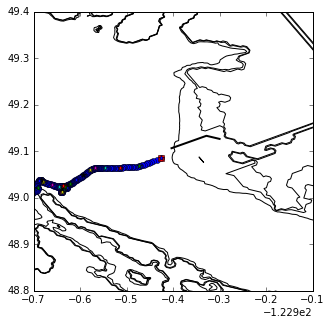

In [18]:
buoy = 6
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,19,10,i=-1)

UBC-I-0007
Released 2014-10-08 19:10:07.999998 at 49.0856266667 , -123.325655 for 23.08361111111111 hours
NEMO coords: 425 287


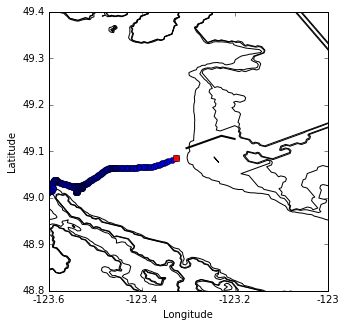

In [28]:
buoy = 6
name, tracks=organize_info(buoy,ubc)
print (name)
fig=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)

In [22]:
fig.savefig('drop323b.png')

UBC-I-0008
Released 2014-10-08 19:20:08.999997 at 49.0943266667 , -123.330828333 for 24.91638888888889 hours
427 287 19.833333333333332
427 287 19.833333333333332 2014-10-08 19:20:08.999997
429 280 20.833333333333332 2014-10-08 20:20:07.999999
432 275 21.833333333333332 2014-10-08 21:20:07.999996
435 272 22.833333333333332 2014-10-08 22:20:08.000002
438 270 23.833333333333332 2014-10-08 23:20:07.999999
440 270 24.833333333333332 2014-10-09 00:20:07.999996
441 271 25.833333333333332 2014-10-09 01:20:08.000002
441 271 26.833333333333332 2014-10-09 02:20:07.999999
440 271 27.833333333333332 2014-10-09 03:20:35
438 271 28.833333333333332 2014-10-09 04:20:06.999998
435 271 29.833333333333332 2014-10-09 05:20:07.999999
433 270 30.833333333333332 2014-10-09 06:20:07.000001
431 269 31.833333333333332 2014-10-09 07:20:06.999998
431 269 32.833333333333336 2014-10-09 08:20:07.999999
433 268 33.833333333333336 2014-10-09 09:20:07.000001
437 268 34.833333333333336 2014-10-09 10:20:08.000002
440 270

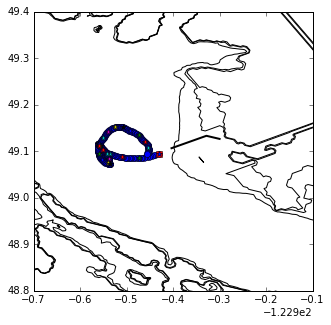

In [19]:
buoy = 7
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,19,20,i=-1)

UBC-I-0008
Released 2014-10-08 19:20:08.999997 at 49.0943266667 , -123.330828333 for 24.91638888888889 hours
NEMO coords: 427 287


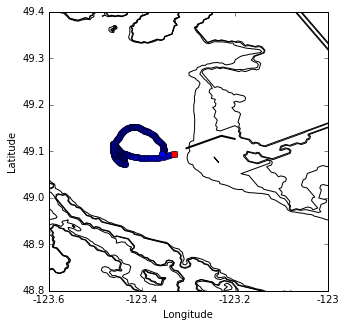

In [29]:
buoy = 7
name, tracks=organize_info(buoy,ubc)
print (name)
fig=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)

In [24]:
fig.savefig('drop23.png')

UBC-I-0010
Released 2014-10-08 19:20:06.999998 at 49.1071733333 , -123.319563333 for 6.666666666111111 hours
429 290 19.833333333333332
429 290 19.833333333333332 2014-10-08 19:20:06.999998
430 293 20.833333333333332 2014-10-08 20:20:07.000005
430 295 21.833333333333332 2014-10-08 21:20:07.999996
429 297 22.833333333333332 2014-10-08 22:20:08.000002
429 298 23.833333333333332 2014-10-08 23:20:07.999999
428 299 24.833333333333332 2014-10-09 00:20:07.999996
428 299 25.833333333333332 2014-10-09 01:20:06.999998


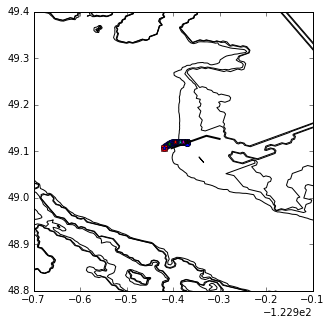

In [20]:
buoy = 9
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
du = calculate_position_onehour(tracks,dt.datetime(2014,10,8),8,19,20,i=-1)

UBC-I-0010
Released 2014-10-08 19:20:06.999998 at 49.1071733333 , -123.319563333 for 6.666666666111111 hours
NEMO coords: 429 290


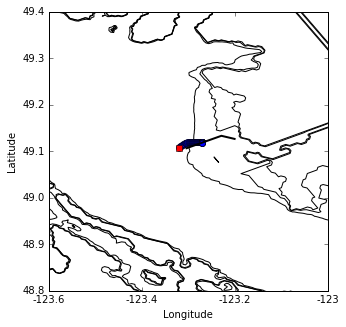

In [30]:
buoy = 9
name, tracks=organize_info(buoy,ubc)
print (name)
fig=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)

In [26]:
fig.savefig('drop13.png')